# Importando as bibliotecas necessárias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.api.callbacks import (
    CSVLogger,
    EarlyStopping,
    ReduceLROnPlateau,
)
from keras.api.layers import LSTM, Dense, Dropout, Input
from keras.api.models import Sequential
from keras.api.optimizers import RMSprop
from keras.api.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

2024-12-02 00:52:26.830104: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 00:52:26.833288: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 00:52:26.862431: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 00:52:26.904522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733111546.945323   45813 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733111546.95

# Carregamento dos Dados Pré-processados

In [2]:
processed_data_path = '../data/processed/normalized_stock_data.csv'
stock_data = pd.read_csv(processed_data_path, index_col=0).sort_values('Date')

stock_data

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1962-01-02,0.000167,0.000975,0.001048,0.001120,0.000962,0.005879
1962-01-03,0.000153,0.000894,0.000897,0.000985,0.000908,0.012068
1962-01-04,0.000158,0.000921,0.000923,0.001048,0.000891,0.006189
1962-01-05,0.000143,0.000840,0.000941,0.000976,0.000908,0.010831
1962-01-08,0.000137,0.000805,0.000790,0.000881,0.000801,0.015782
...,...,...,...,...,...,...
2024-10-25,0.922834,0.916367,0.920504,0.924238,0.914783,0.089138
2024-10-28,0.919384,0.912933,0.916413,0.921601,0.913278,0.086102
2024-10-29,0.904069,0.897690,0.901959,0.906616,0.904114,0.132555


In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
stock_data['Close'] = scaler.fit_transform(stock_data[['Close']])


# Criando sequências para treinamento
def create_sequences(data: np.ndarray, time_step: int):
    """
    Cria sequências e valores-alvo para uma série temporal.

    Args:
        data (np.ndarray): Array unidimensional dos dados normalizados.
        time_step (int): Tamanho da janela temporal.

    Returns:
        np.ndarray: Matrizes de entrada (X) e valores-alvo (y).
    """
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i : i + time_step])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)


time_step = 60
X, y = create_sequences(stock_data['Close'].to_numpy(), time_step)

# Divisão dos Dados em Treino e Teste

In [4]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Exibindo as dimensões dos dados
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (12605, 60), y_train shape: (12605,)
X_test shape: (3152, 60), y_test shape: (3152,)


# Construção do Modelo LSTM

In [5]:
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(32, kernel_regularizer=l2(0.02), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')  # type: ignore

model.summary()

W0000 00:00:1733111549.512435   45813 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           425 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,939 (31.01 KB)

 Trainable params: 7,939 (31.01 KB)

 Non-trainable params: 0 (0.00 B)

# Treinamento do Modelo

In [6]:
# Stops training if performance starts to degrade
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback to log details to a CSV file
csv_logger = CSVLogger('../logs/training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, reduce_lr, csv_logger]

In [7]:
# Treinando o modelo
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=25,
    callbacks=callbacks_list,
)

Epoch 1/100
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0194 - val_loss: 0.0358 - learning_rate: 0.0010
Epoch 2/100
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0013 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 3/100
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0010 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 4/100
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 9.3293e-04 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 5/100
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 8.7790e-04 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 6/100
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 8.1665e-04 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 7/100
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 7.9125e-04 - val_loss: 0.0158 - learning_rate: 0.0010
Epoch 8/100
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 7.2919e-04 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 9/100
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 6.9130e-04 - val_loss

# Avaliação do Modelo

In [10]:
predictions = model.predict(X_test)

# Revertendo a normalização
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculando métricas de desempenho
mae = mean_absolute_error(y_test_scaled, predictions)
rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions))
mape = np.mean(np.abs((y_test_scaled - predictions) / y_test_scaled)) * 100
r2 = r2_score(y_test_scaled, predictions)

# Exibindo os resultados
print(f'MAE (Mean Absolute Error): {mae}')
print(f'RMSE (Root Mean Squared Error): {rmse}')
print(f'MAPE (Mean Absolute Percentage Error): {mape}%')
print(f'R² Score: {r2}')

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MAE (Mean Absolute Error): 0.030567265368714226
RMSE (Root Mean Squared Error): 0.03730751296018038
MAPE (Mean Absolute Percentage Error): 4.661106174899045%
R² Score: 0.9023744917694514


# Historico de Treinamento


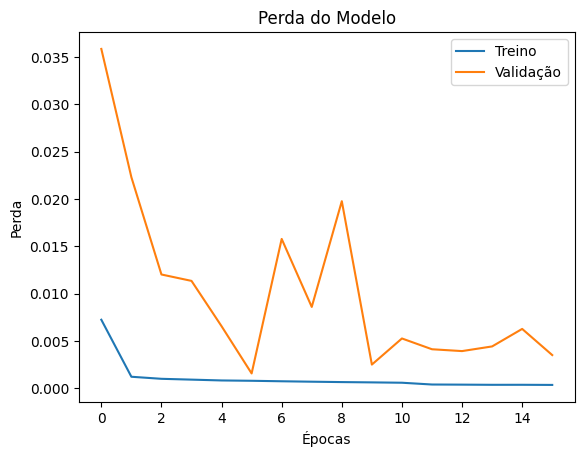

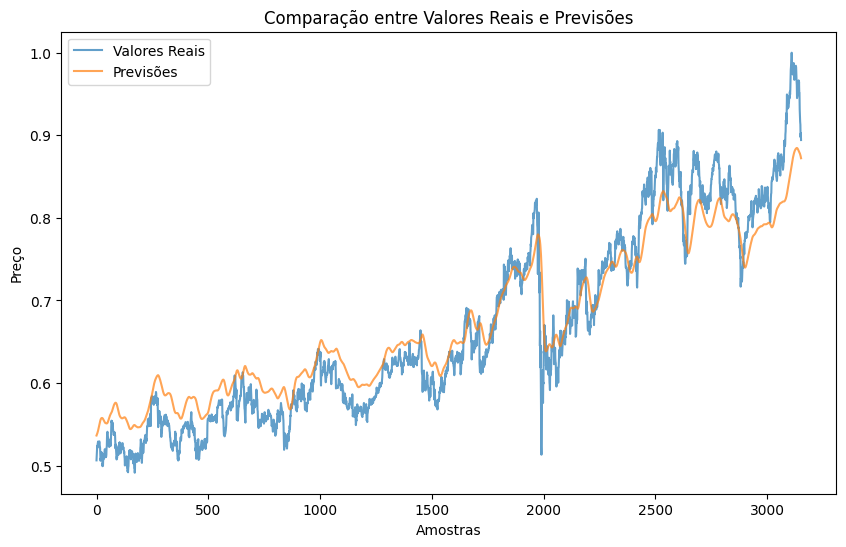

In [11]:
# Plotando a perda durante o treinamento
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Comparando previsões com valores reais
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, label='Valores Reais', alpha=0.7)
plt.plot(predictions, label='Previsões', alpha=0.7)
plt.title('Comparação entre Valores Reais e Previsões')
plt.xlabel('Amostras')
plt.ylabel('Preço')
plt.legend()
plt.show()

In [12]:
pd.DataFrame(
    data={'Valor real': y_test_scaled.flatten(), 'Valor predito': predictions.flatten()}
)

,Valor real,Valor predito
0,0.506303,0.536394
1,0.511865,0.537072
2,0.517221,0.537767
3,0.523538,0.538522
4,0.521409,0.539358
...,...,...
3147,0.916367,0.876928
3148,0.912933,0.875973
3149,0.897690,0.874895
3150,0.902634,0.873626


# Testando o modelo com dados reais

Buscamos agora um intervalo dos dados mais atualizados da Coca-Cola no yFinance, pegando um período adequado ao que nosso modelo foi treinado.

Com nosso modelo, podemos prever os próximos N valores:

In [44]:
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

test_data = yf.download('KO', period='3mo', interval='1d')
test_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,KO,KO,KO,KO,KO,KO
Date,,,,,,
2024-08-30 00:00:00+00:00,71.434746,72.470001,72.570000,71.779999,72.199997,18624200
2024-09-03 00:00:00+00:00,71.967033,73.010002,73.290001,72.250000,72.440002,14755800
2024-09-04 00:00:00+00:00,71.523460,72.559998,73.529999,71.910004,73.300003,18140800
2024-09-05 00:00:00+00:00,70.153320,71.169998,72.680000,70.980003,72.620003,23866100
2024-09-06 00:00:00+00:00,70.123749,71.139999,71.669998,70.889999,70.989998,17485700
...,...,...,...,...,...,...
2024-11-22 00:00:00+00:00,63.438839,63.919998,64.480003,63.650002,64.239998,19562200
2024-11-25 00:00:00+00:00,63.895374,64.379997,64.709999,63.840000,64.320000,36805300


In [47]:
# Select 'Close' price and scale it
closing_prices = test_data['Close'].to_numpy().reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)
scaled_data

array([[0.9520851 ],
       [1.        ],
       [0.96007058],
       [0.83673435],
       [0.83407252],
       [0.89707155],
       [0.87045262],
       [0.82874887],
       [0.84205868],
       [0.85803031],
       [0.91925434],
       [0.8926354 ],
       [0.88819857],
       [0.78793263],
       [0.87843809],
       [0.88642425],
       [0.85093166],
       [0.86157896],
       [0.85714281],
       [0.8917479 ],
       [0.89795905],
       [0.88464925],
       [0.82253772],
       [0.77905897],
       [0.74800321],
       [0.64507544],
       [0.66015957],
       [0.69476466],
       [0.66637072],
       [0.69476466],
       [0.76308734],
       [0.76308734],
       [0.7834958 ],
       [0.7240461 ],
       [0.77196099],
       [0.68411668],
       [0.68411668],
       [0.55634429],
       [0.49334527],
       [0.459627  ],
       [0.43744421],
       [0.33895259],
       [0.37089586],
       [0.31676981],
       [0.29015087],
       [0.29902385],
       [0.32209414],
       [0.173

In [49]:
predicted_prices = []
current_batch = scaled_data[-60:]

for _ in range(30):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch, next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print('Predicted Stock Prices for the next 30 days: ', predicted_prices)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━

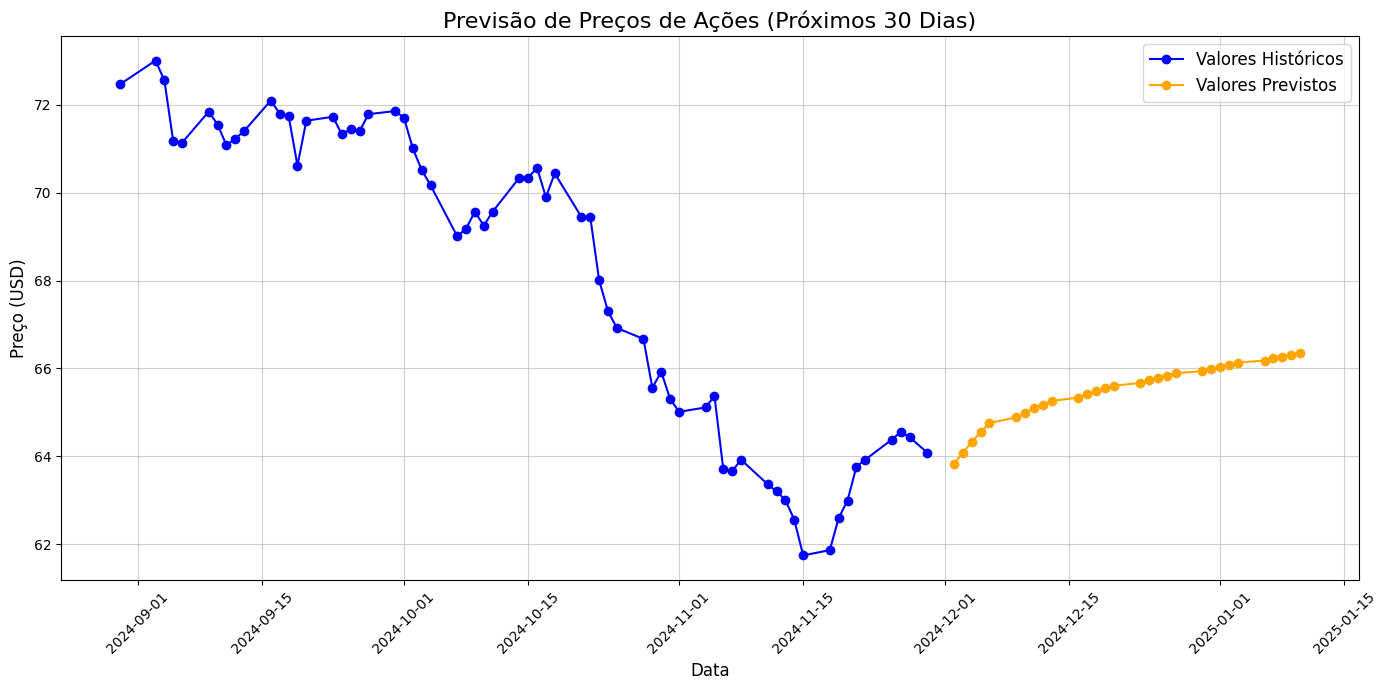

In [58]:
# Valores históricos (atuais)
historical_prices = test_data['Close'].to_numpy()

# Geração das datas futuras
start_date = test_data.index[-1]  # Última data do dataset atual
future_dates = pd.date_range(
    start=start_date, periods=len(predicted_prices) + 1, freq='B'
)[1:]  # Excluindo a última data

# Criar o gráfico
plt.figure(figsize=(14, 7))

# Plotando os valores históricos
plt.plot(
    test_data.index,
    historical_prices,
    label='Valores Históricos',
    color='blue',
    marker='o',
    linestyle='-',
)

# Plotando os valores previstos
plt.plot(
    future_dates,
    predicted_prices,
    label='Valores Previstos',
    color='orange',
    marker='o',
    linestyle='-',
)

# Adicionando título e rótulos
plt.title('Previsão de Preços de Ações (Próximos 30 Dias)', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='-', alpha=0.6)

# Legenda para diferenciar os conjuntos
plt.legend(fontsize=12)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()

Na visualização acima, conseguimos ver alguns pontos interessantes:
- Os valores previstos possuem espaços a cada cinco valores, representando os finais de semana (dias sem um valor de Close)
- Nos últimos meses os valores caíram, porém o modelo está prevendo uma subida nos valores. Talvez isso ocorreu por conta de:
    - Em nossa base de treino do modelo, ele foi treinado com dados que foram subindo com o passar do tempo
    - Talvez por conta das últimas semanas (dia 15 até final do mês) o valor ter subido
    - Como estamos prevendo dados para o começo do ano e geralmente essas datas possuem um valor de Close mais alto, ele tentou refletir isso nas previsões


# Salvando o modelo

In [59]:
model_save_path = '../models/lstm_stock_prediction_model.h5'
model.save(model_save_path)